<a href="https://colab.research.google.com/github/huseyincavusbi/medgemma-attn/blob/main/medgemma_attn_visual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -U transformers accelerate

from huggingface_hub import notebook_login
notebook_login()

In [4]:
# Load the tokenizer AND the processor for multimodal inputs

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoProcessor
import torch

model_id = "google/medgemma-4b-it"

# The tokenizer is great for text-only tasks
tokenizer = AutoTokenizer.from_pretrained(model_id)

# The processor handles both text tokenization and image preprocessing
processor = AutoProcessor.from_pretrained(model_id)

# Load the model, specifying the data type and forcing the "eager" attention implementation
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="eager", # supports feature extraction, at the cost of some performance. -eager vs sdpa-
)

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

In [5]:
# Define the input text, a simple medical question
input_text = "What are the key differences between bacterial and viral pneumonia?"

# Tokenize the input text and convert it to PyTorch tensors
inputs = tokenizer(input_text, return_tensors="pt").to(model.device)

In [6]:
# Perform a forward pass and get the model outputs
# Set output_attentions=True to get the attention weights
with torch.no_grad():
  outputs = model(**inputs, output_attentions=True)

# The attention weights are in the 'attentions' key of the output
attention = outputs.attentions

In [7]:
print(f"Number of layers: {len(attention)}")

# Get the attention tensor for the first layer
first_layer_attention = attention[0]

print(f"Shape of the first layer's attention tensor: {first_layer_attention.shape}")

Number of layers: 34
Shape of the first layer's attention tensor: torch.Size([1, 8, 12, 12])


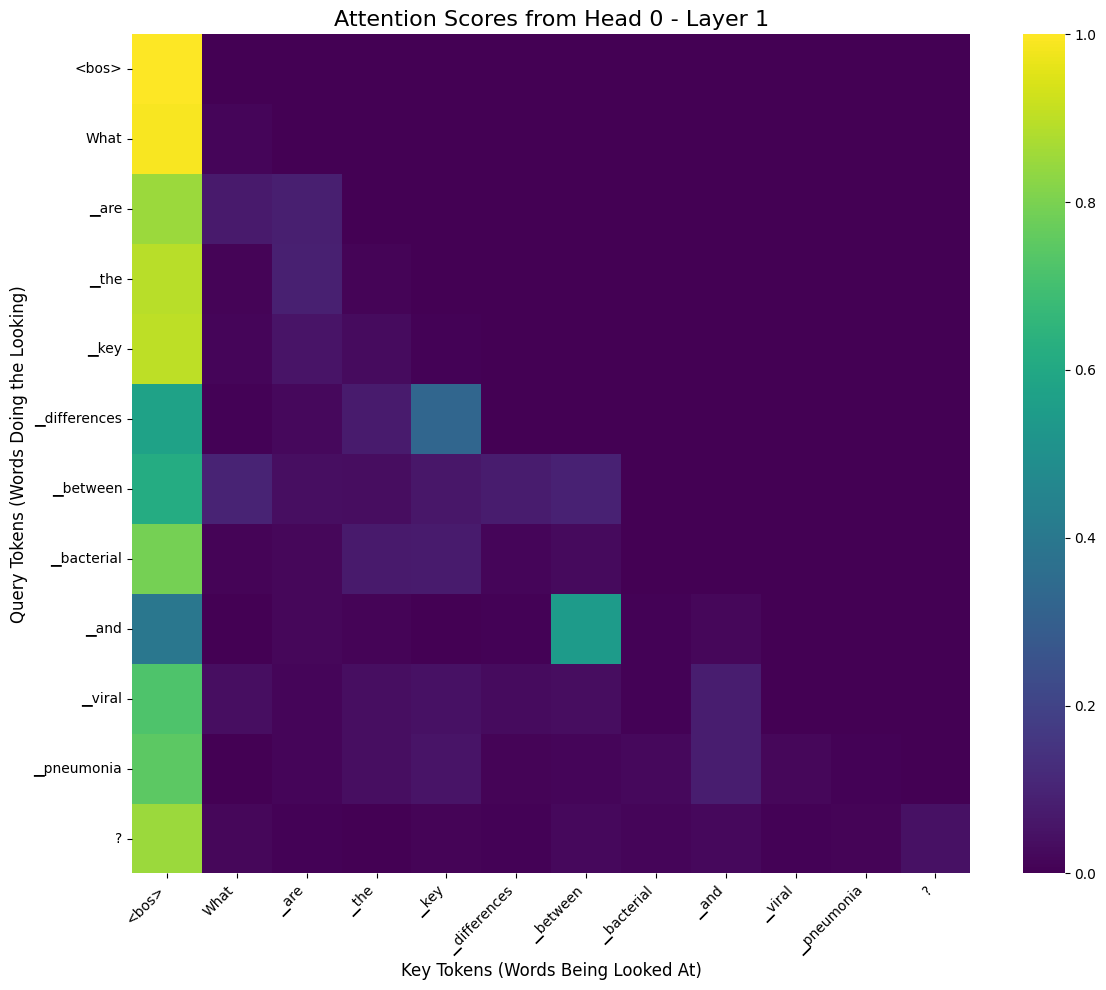

In [8]:
# Visualize Attention with a Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Let's visualize the attention from the first head of the first layer
# We select the first batch [0] and the first attention head [0]
# Add .float() to convert from bfloat16 to a standard float32
attention_head_0 = attention[0][0, 0].cpu().float().numpy()

# Get the tokens from the tokenizer to use as labels
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(attention_head_0, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("Attention Scores from Head 0 - Layer 1", fontsize=16)
plt.xlabel("Key Tokens (Words Being Looked At)", fontsize=12)
plt.ylabel("Query Tokens (Words Doing the Looking)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The <bos> token attracts a lot of attention at first. As the sentence progresses, we observe that attention shifts to other tokens.

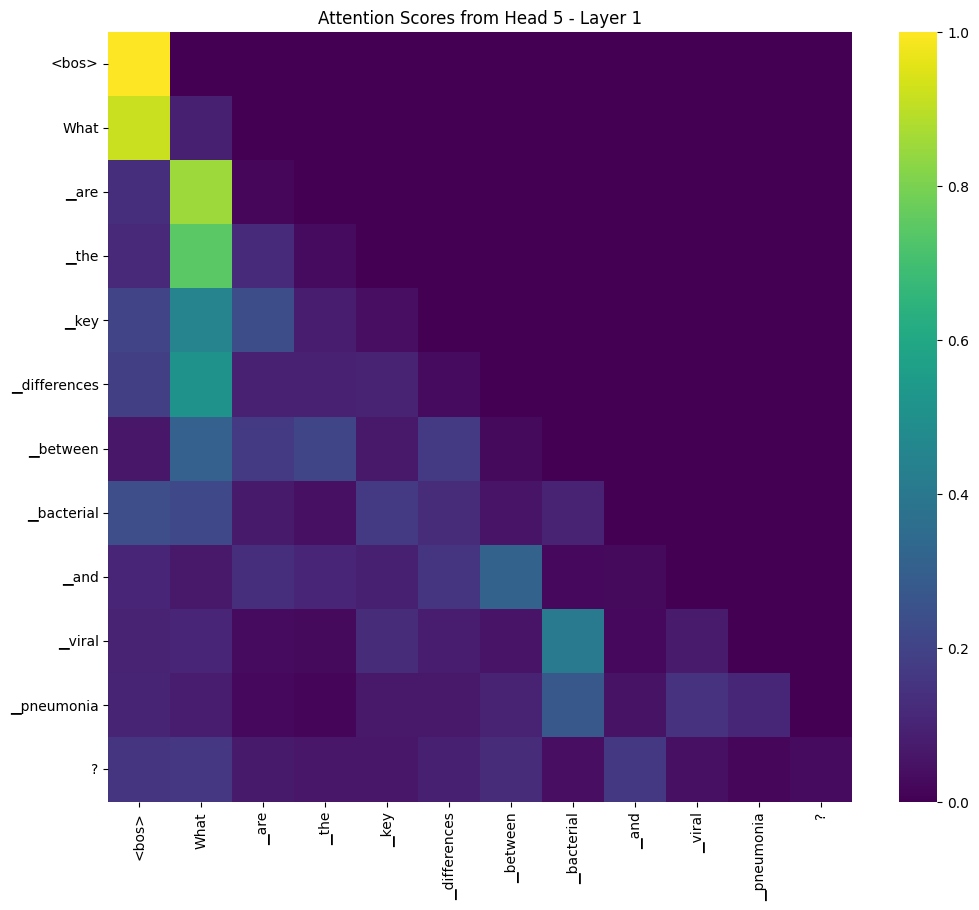

In [9]:
# Let's visualize the attention from Head 5 of the first layer
attention_head_5 = attention[0][0, 5].cpu().float().numpy()
plt.figure(figsize=(12, 10))
sns.heatmap(attention_head_5, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("Attention Scores from Head 5 - Layer 1")
plt.show()

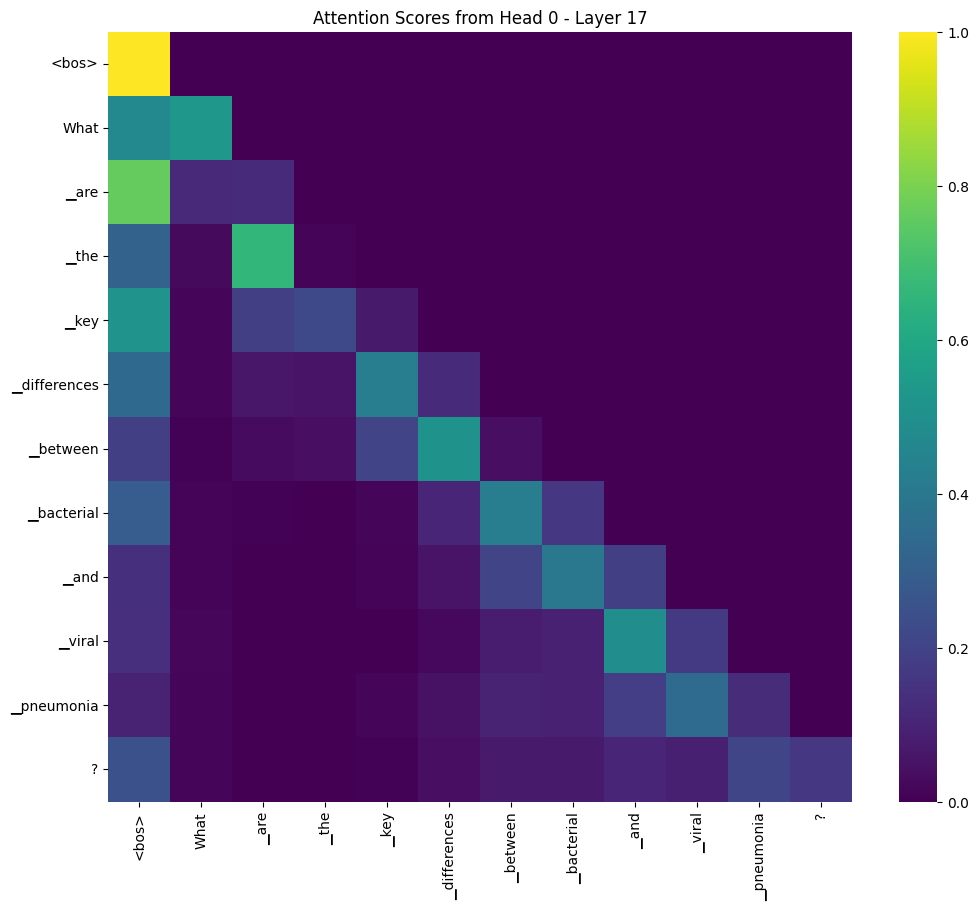

In [10]:
# Get the attention tensor for a middle layer
middle_layer_attention = attention[16]

# Let's visualize the attention from the first head of this middle layer
attention_middle_layer_head_0 = middle_layer_attention[0, 0].cpu().float().numpy()

plt.figure(figsize=(12, 10))
sns.heatmap(attention_middle_layer_head_0, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("Attention Scores from Head 0 - Layer 17")
plt.show()

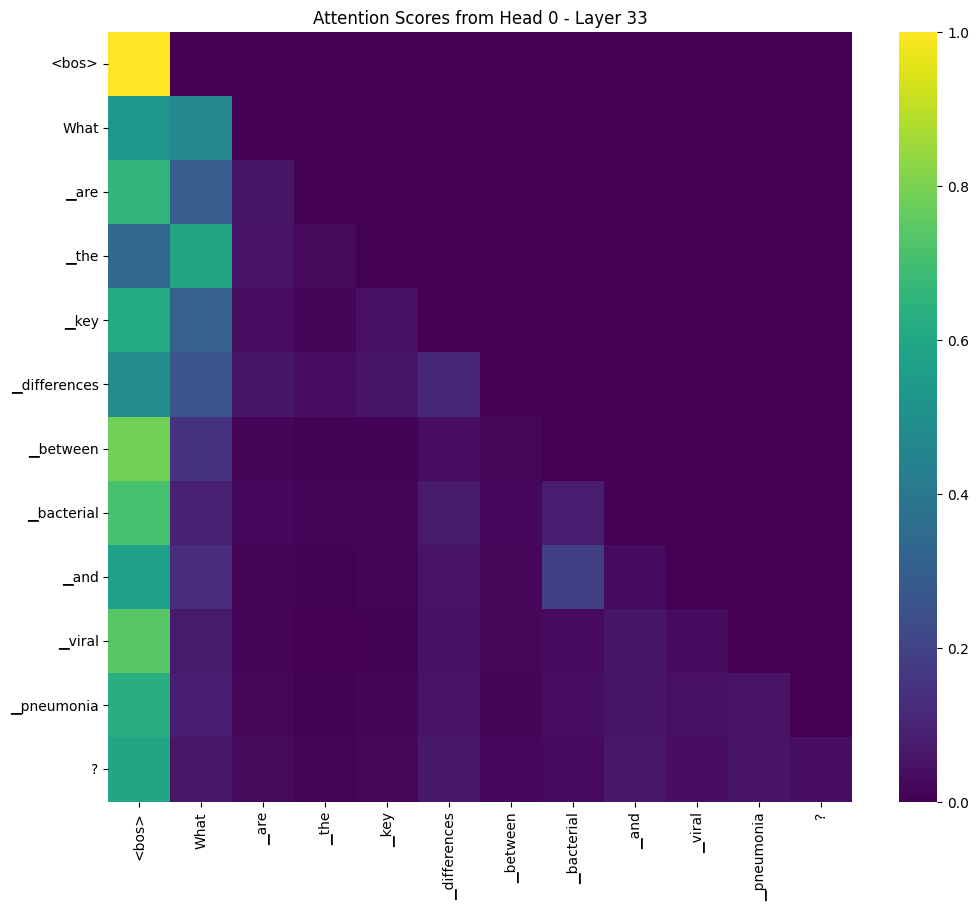

In [11]:
# Get the attention tensor for a layer 33
middle_layer_attention = attention[33]

# Visualize the attention from the first head of this layer
attention_middle_layer_head_0 = middle_layer_attention[0, 0].cpu().float().numpy()

plt.figure(figsize=(12, 10))
sns.heatmap(attention_middle_layer_head_0, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("Attention Scores from Head 0 - Layer 33")
plt.show()

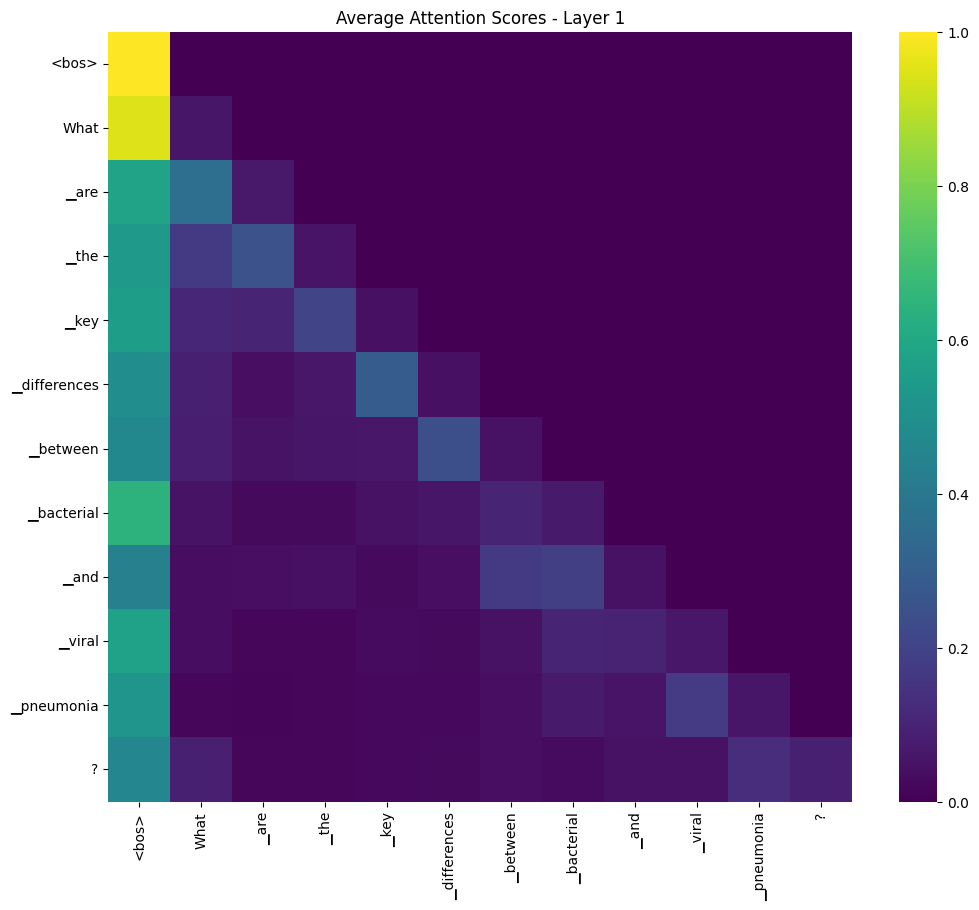

In [12]:
# Get the attention tensor for the first layer
first_layer_attention = attention[0]

# Calculate the mean across the 8 heads (dimension 1)
mean_attention_layer_1 = first_layer_attention[0].mean(dim=0).cpu().float().numpy()


plt.figure(figsize=(12, 10))
sns.heatmap(mean_attention_layer_1, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("Average Attention Scores - Layer 1")
plt.show()

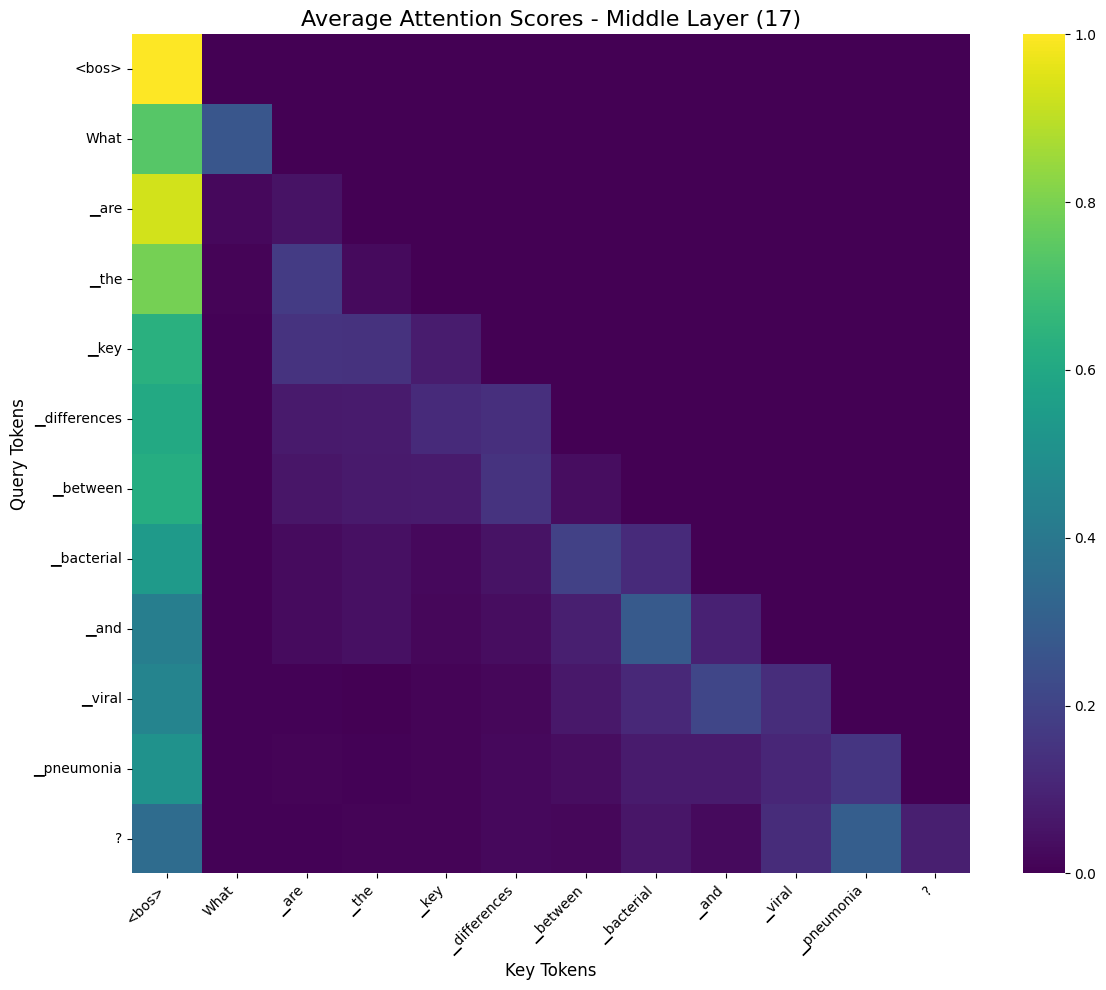

In [13]:
# Get the attention tensor for a middle layer (layer 17)
middle_layer_attention = attention[16]

# Calculate the mean across the 8 heads
mean_attention_middle_layer = middle_layer_attention[0].mean(dim=0).cpu().float().numpy()

plt.figure(figsize=(12, 10))
sns.heatmap(mean_attention_middle_layer, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("Average Attention Scores - Middle Layer (17)", fontsize=16)
plt.xlabel("Key Tokens", fontsize=12)
plt.ylabel("Query Tokens", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

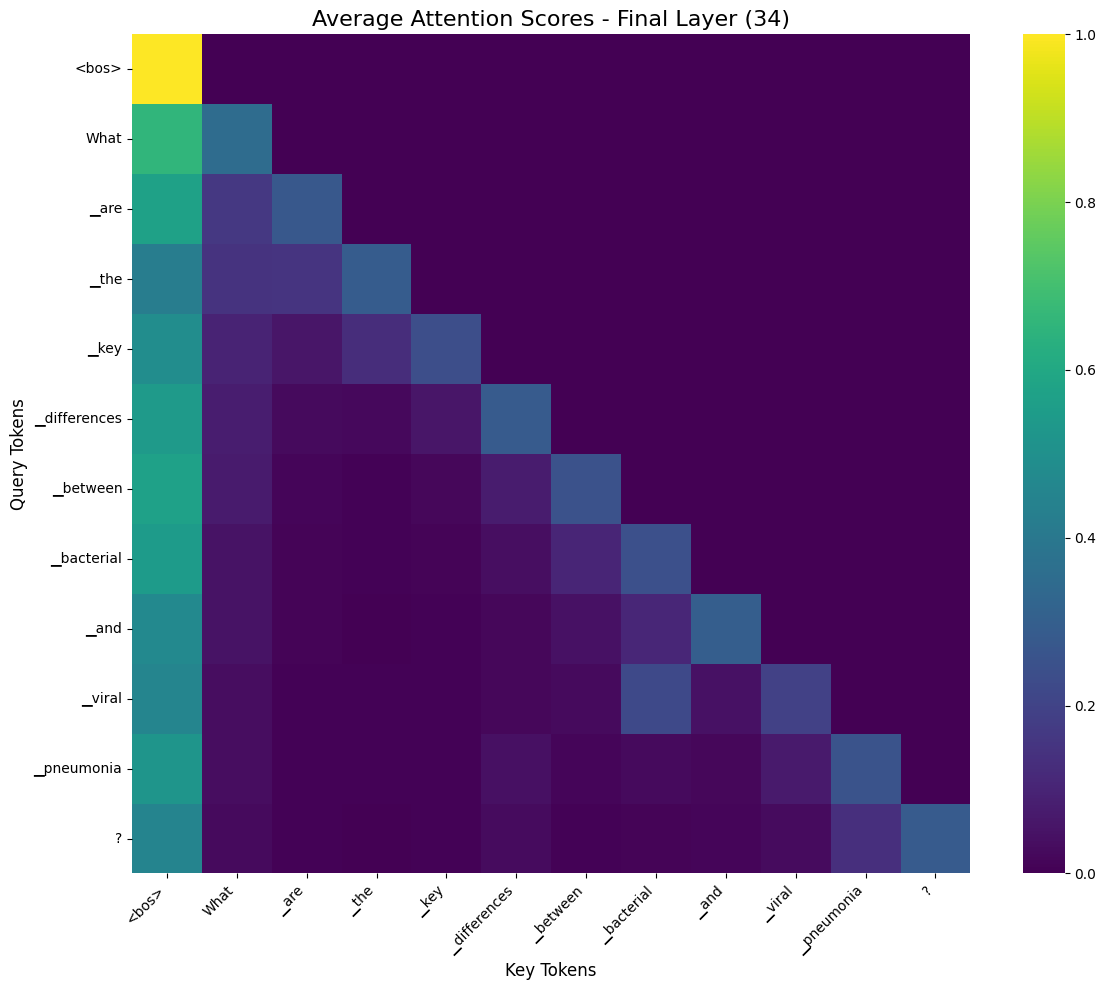

In [14]:
# Analyze the Final Layer
final_layer_attention = attention[33]

mean_attention_final_layer = final_layer_attention[0].mean(dim=0).cpu().float().numpy()

plt.figure(figsize=(12, 10))
sns.heatmap(mean_attention_final_layer, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("Average Attention Scores - Final Layer (34)", fontsize=16)
plt.xlabel("Key Tokens", fontsize=12)
plt.ylabel("Query Tokens", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [15]:
# Generate a short response, instructing the model to return the attention scores
with torch.no_grad():
  outputs = model.generate(
      **inputs,
      max_new_tokens=20,
      output_attentions=True,
      return_dict_in_generate=True
  )

# The generated token IDs are in the 'sequences' key
generated_tokens = outputs.sequences

# The attention scores are now in a more complex structure, a tuple of tuples
attentions = outputs.attentions

In [16]:
# Decode the generated sequence of tokens back into human-readable text
response_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

print("Input Prompt:\n", input_text)
print("-" * 20)
print("Generated Response:\n", response_text)

# Let's also see how many new tokens were generated
num_input_tokens = inputs.input_ids.shape[1]
num_generated_tokens = len(attentions)
print(f"\nNumber of generated tokens: {num_generated_tokens}")

Input Prompt:
 What are the key differences between bacterial and viral pneumonia?
--------------------
Generated Response:
 What are the key differences between bacterial and viral pneumonia?

Bacterial pneumonia and viral pneumonia are both infections of the lungs that cause inflammation and fluid buildup in

Number of generated tokens: 20


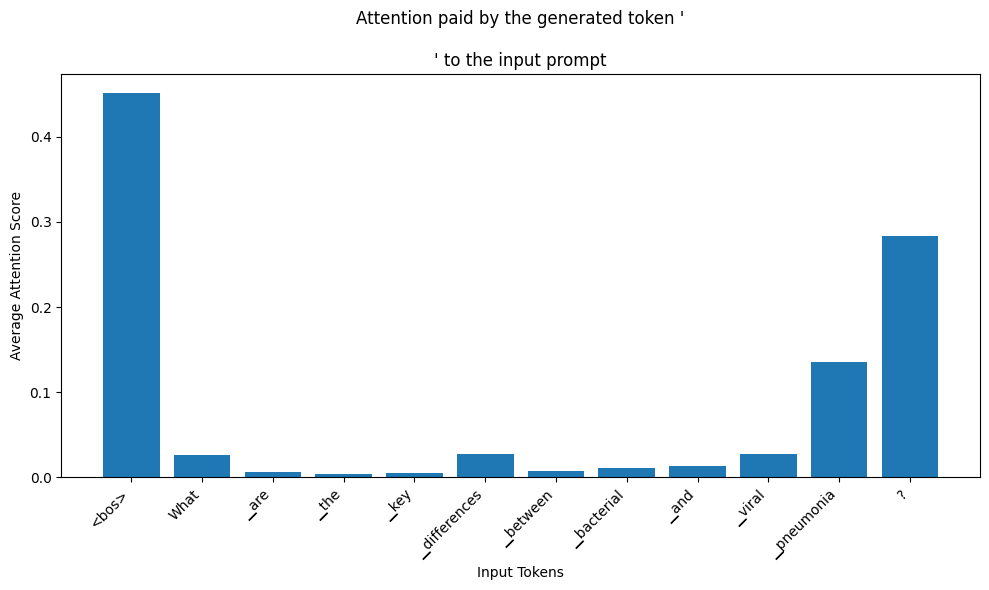

In [17]:
# Let's analyze the attention for the VERY FIRST generated token
first_generated_token_attentions = attentions[0] # Tuple of attention scores for each layer

# We'll inspect the final layer's attention, as it's most relevant to the decision
# Shape: (batch_size, num_heads, sequence_length, sequence_length)
final_layer_attention_for_first_token = first_generated_token_attentions[-1] # Get final layer

# Average the attention scores across all heads for a clearer view
# We only care about the last query token (the one being generated) so we take the scores from the last row.
attention_scores = final_layer_attention_for_first_token[0, :, -1, :].mean(dim=0).cpu().float().numpy()

# Get the original input tokens for labeling our chart
input_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Get the first generated token itself
first_generated_word = tokenizer.decode(generated_tokens[0][num_input_tokens])

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(input_tokens)), attention_scores)
plt.xticks(range(len(input_tokens)), input_tokens, rotation=45, ha="right")
plt.title(f"Attention paid by the generated token '{first_generated_word}' to the input prompt")
plt.ylabel("Average Attention Score")
plt.xlabel("Input Tokens")
plt.tight_layout()
plt.show()

Before writing a single word, the model's final layer "thinks":
"Okay, I've processed the entire input, and the question mark (?) tells me the user is done asking. Looking at my overall context (<bos>), I know the main topic is pneumonia. The standard procedure now is to start my response. I'll begin with a simple space for formatting, and then I'll start formulating the real answer."

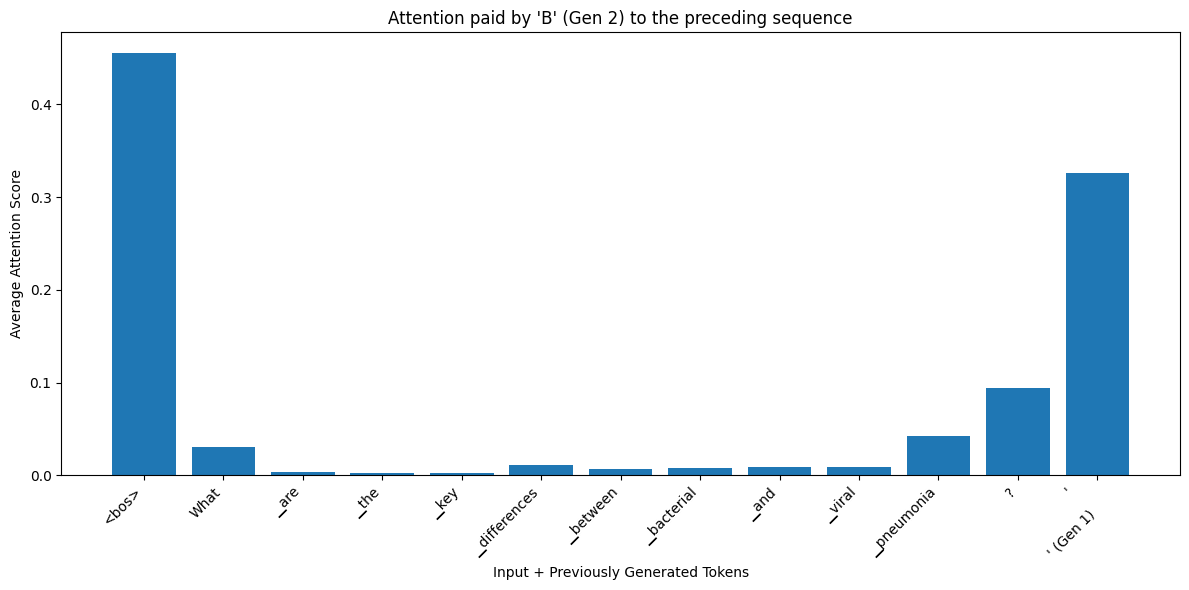

In [18]:
# Let's analyze the attention for the SECOND generated token (index 1)
second_generated_token_attentions = attentions[1]

# Inspect the final layer's attention
final_layer_attention_for_second_token = second_generated_token_attentions[-1]

# Average the attention scores across all heads
attention_scores = final_layer_attention_for_second_token[0, :, -1, :].mean(dim=0).cpu().float().numpy()


# 1. Get the list of original input tokens
input_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# 2. Get the first generated token as a string
num_input_tokens = inputs.input_ids.shape[1]
first_generated_word = tokenizer.decode(generated_tokens[0][num_input_tokens])

# 3. Create the new, updated list of labels for the x-axis
# This list now includes the first generated token.
token_labels = input_tokens + [f"'{first_generated_word}' (Gen 1)"]

# 4. Get the second generated token for the title
second_generated_word = tokenizer.decode(generated_tokens[0][num_input_tokens + 1])


# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(token_labels)), attention_scores) # Use the new labels list for the range
plt.xticks(range(len(token_labels)), token_labels, rotation=45, ha="right") # And for the ticks
plt.title(f"Attention paid by '{second_generated_word}' (Gen 2) to the preceding sequence")
plt.ylabel("Average Attention Score")
plt.xlabel("Input + Previously Generated Tokens")
plt.tight_layout()
plt.show()

"Okay, I've started my response. I need to begin addressing the core question about the 'differences'. My training suggests the best way to do this is to discuss the first item mentioned. I will start the word 'Bacterial'. To do this, I must focus on the space I just wrote (' ') for continuity and on my overall mission (<bos>) to ensure I'm still on topic."  // (Gen 2 = 2nd generated token)

<bos>What are the key differences between bacterial and viral pneumonia?

Bacterial pneumonia and viral pneumonia are both infections of the lungs that cause inflammation and fluid buildup in the air sacs (alveoli). However, they differ in their causes, symptoms, and treatments.


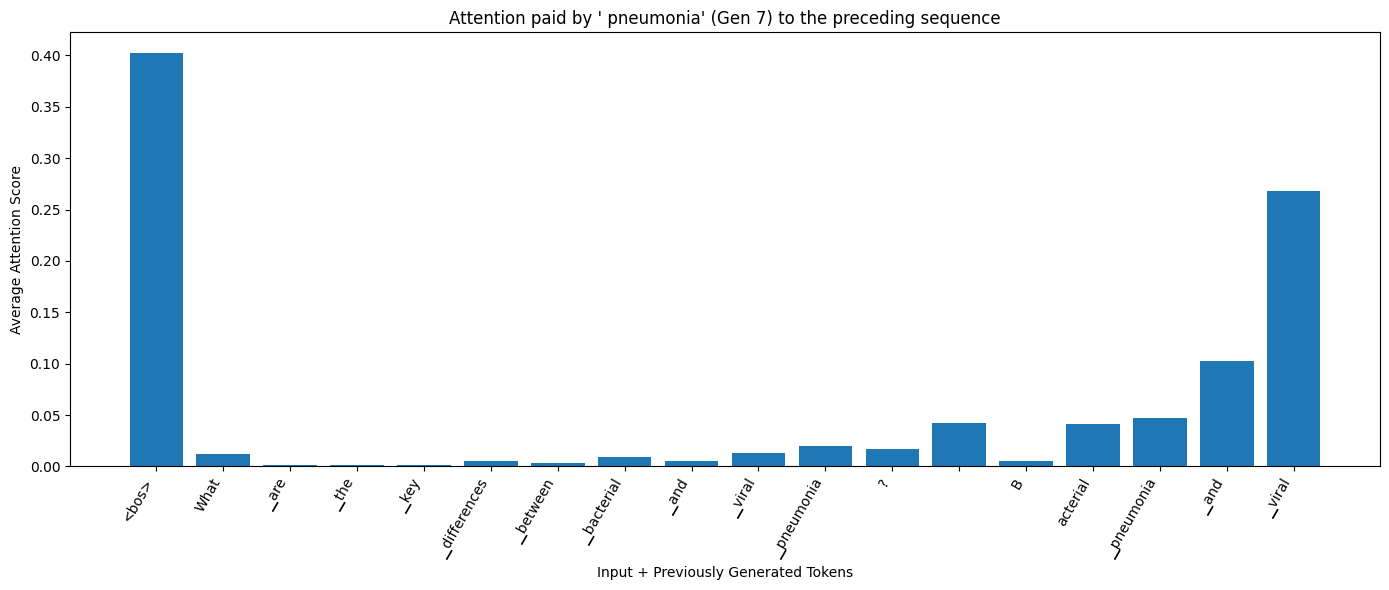

In [19]:
# Step 1: Generate a longer response
with torch.no_grad():
  outputs = model.generate(
      **inputs,
      max_new_tokens=40,
      output_attentions=True,
      return_dict_in_generate=True
  )
generated_tokens = outputs.sequences
attentions = outputs.attentions

# Step 2: Decode the full response and find your target word
full_response = tokenizer.decode(generated_tokens[0])
print(full_response)

# Manually inspect the output above and choose a target token index
# We start at 0
target_gen_index = 6

# Step 3: Plot the attention for the chosen pivot word
if target_gen_index < len(attentions):
    num_input_tokens = inputs.input_ids.shape[1]
    pivot_attentions = attentions[target_gen_index][-1] # Final layer

    # The sequence length grows with each step
    current_seq_len = num_input_tokens + target_gen_index

    # Get the attention scores for the pivot word looking at all previous tokens
    attention_scores = pivot_attentions[0, :, -1, :].mean(dim=0).cpu().float().numpy()

    # Create the correct labels for the x-axis
    previous_tokens = tokenizer.convert_ids_to_tokens(generated_tokens[0][:current_seq_len])
    pivot_word = tokenizer.decode(generated_tokens[0][current_seq_len])

    # Plotting
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(previous_tokens)), attention_scores)
    plt.xticks(range(len(previous_tokens)), previous_tokens, rotation=60, ha="right")
    plt.title(f"Attention paid by '{pivot_word}' (Gen {target_gen_index+1}) to the preceding sequence")
    plt.ylabel("Average Attention Score")
    plt.xlabel("Input + Previously Generated Tokens")
    plt.tight_layout()
    plt.show()
else:
    print(f"Error: Only {len(attentions)} tokens were generated. Please choose an index less than that.")

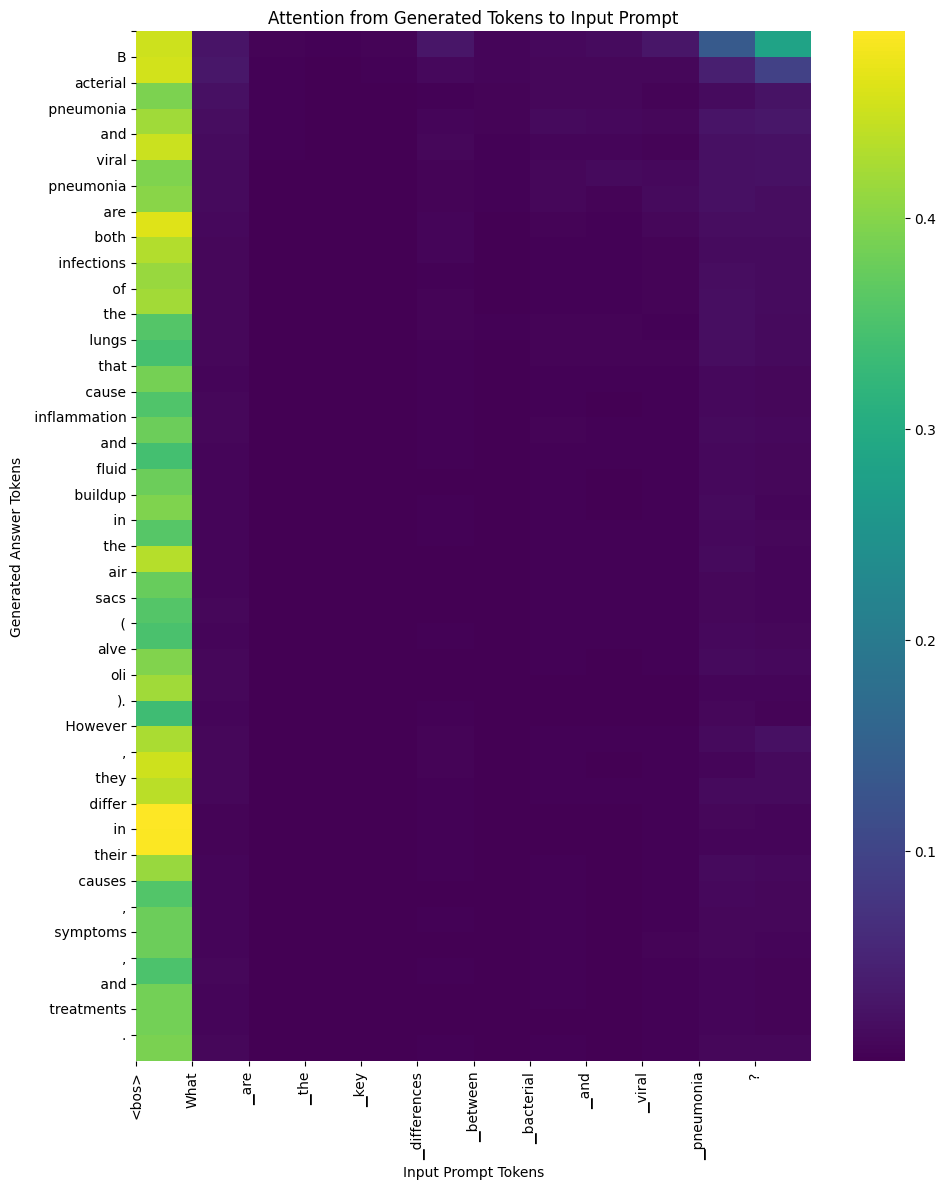

In [20]:
# Use the longer 'outputs' generated in Level 1

num_input_tokens = inputs.input_ids.shape[1]
num_generated_tokens = len(attentions)

# We will collect the final layer's attention from each generation step focusing only on the attention paid back to the *original* input prompt
attention_matrix = []

for i in range(num_generated_tokens):
    # Get final layer attention for the i-th generated token
    final_layer_attention = attentions[i][-1]

    # Get the scores from the token being generated, looking back at the original input
    # Shape: (num_heads, input_token_len)
    attention_to_input = final_layer_attention[0, :, -1, :num_input_tokens]

    # Average across the heads and append
    attention_matrix.append(attention_to_input.mean(dim=0).cpu().float())

# Stack into a single tensor
attention_matrix = torch.stack(attention_matrix)

# Get labels for the axes
input_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
generated_ids = generated_tokens[0][num_input_tokens:]
generated_words = [tokenizer.decode(g_id) for g_id in generated_ids]


# Plot the master heatmap
fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(attention_matrix, cmap="viridis", ax=ax)

ax.set_xticks(range(len(input_tokens)))
ax.set_xticklabels(input_tokens, rotation=90)
ax.set_yticks(range(len(generated_words)))
ax.set_yticklabels(generated_words, rotation=0)
ax.set_xlabel("Input Prompt Tokens")
ax.set_ylabel("Generated Answer Tokens")
ax.set_title("Attention from Generated Tokens to Input Prompt")
plt.tight_layout()
plt.show()

In [21]:
# Multi-Step Prompt

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define the Multi-Step Prompt
input_text = "First, define bacterial pneumonia. Second, list three common symptoms. Finally, explain why it is treated with antibiotics and not antivirals."
inputs = tokenizer(input_text, return_tensors="pt").to(model.device)

# 2. Generate a Long Response to Capture All Tasks
with torch.no_grad():
  outputs = model.generate(
      **inputs,
      max_new_tokens=150,
      output_attentions=True,
      return_dict_in_generate=True
  )

# 3. Extract and Prepare Data for Visualization
attentions = outputs.attentions
generated_tokens = outputs.sequences

# Decode the full response for context
full_response = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
print("--- MODEL RESPONSE ---")
print(full_response)
print("--- END RESPONSE ---")

# Prepare the data matrices and labels that will be used by all plots
num_input_tokens = inputs.input_ids.shape[1]
num_generated_tokens = len(attentions)

attention_matrix = []
for i in range(num_generated_tokens):
    final_layer_attention = attentions[i][-1]
    attention_to_input = final_layer_attention[0, :, -1, :num_input_tokens]
    attention_matrix.append(attention_to_input.mean(dim=0).cpu().float())

attention_matrix = torch.stack(attention_matrix)
input_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
generated_ids = generated_tokens[0][num_input_tokens:]
generated_words = [tokenizer.decode(g_id).strip() for g_id in generated_ids]

print("\nData is ready for visualization.")

--- MODEL RESPONSE ---
First, define bacterial pneumonia. Second, list three common symptoms. Finally, explain why it is treated with antibiotics and not antivirals.

Bacterial pneumonia is an infection of the lungs caused by bacteria.

Three common symptoms of bacterial pneumonia are:

*   Cough
*   Fever
*   Chest pain

Bacterial pneumonia is treated with antibiotics because it is caused by bacteria. Antibiotics are medications that specifically target and kill bacteria. Antivirals, on the other hand, are medications that target and kill viruses. Since bacterial pneumonia is caused by bacteria, antibiotics are the appropriate treatment.

Final Answer: The final answer is $\boxed{antibiotics}$
Final Answer: The final answer is $\boxed{antibiotics}$
Final Answer: The final answer is $\boxed{antibiotics}$
Final Answer: The final answer is $\boxed{antibiotics
--- END RESPONSE ---

Data is ready for visualization.


Found pivot points at generated token indices: 15 and 43


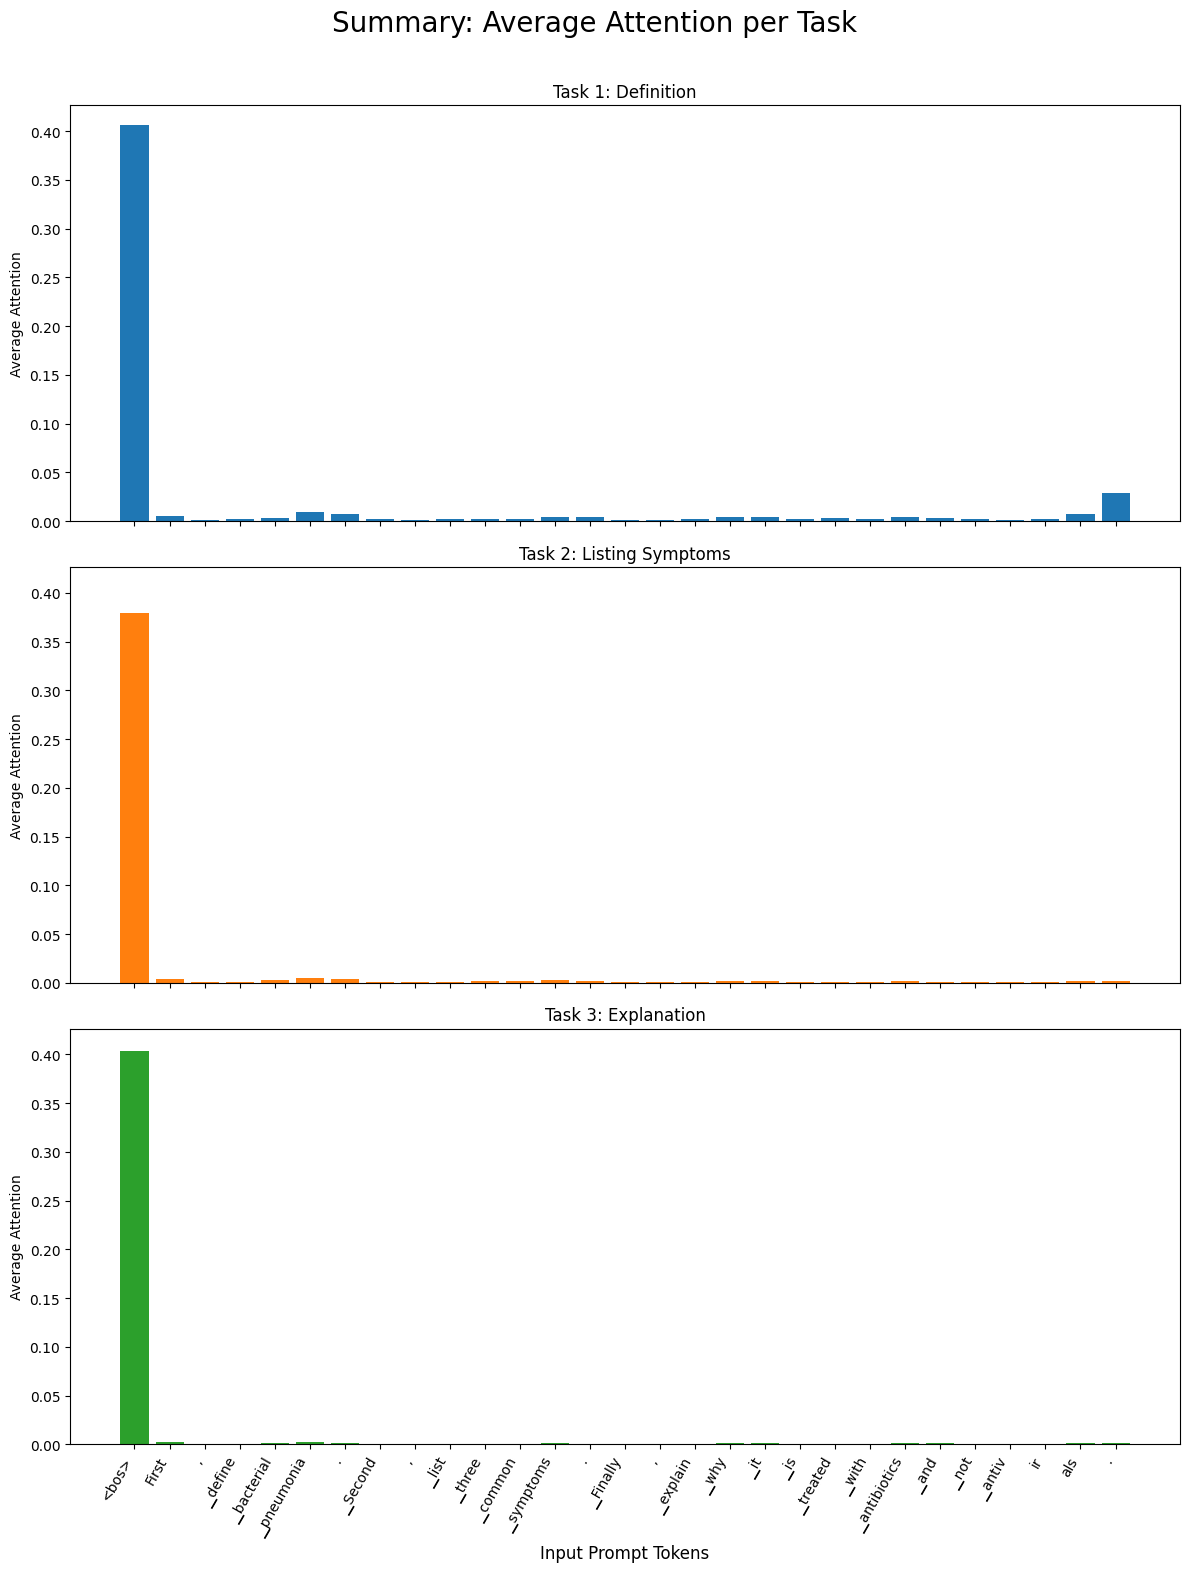

In [22]:
# 1. Find Pivot Indices Automatically
try:
    pivot_index_1 = generated_words.index('Three')
    pivot_index_2 = [i for i, s in enumerate(generated_words) if 'treated' in s][0]
    print(f"Found pivot points at generated token indices: {pivot_index_1} and {pivot_index_2}")
except (ValueError, IndexError) as e:
    print(f"Could not find pivot words automatically, plotting might fail. Error: {e}")
    pivot_index_1, pivot_index_2 = len(generated_words)//3, 2*len(generated_words)//3 # Fallback

# 2. Calculate Average Attention for Each Task
avg_att_task1 = attention_matrix[:pivot_index_1].mean(axis=0)
avg_att_task2 = attention_matrix[pivot_index_1:pivot_index_2].mean(axis=0)
avg_att_task3 = attention_matrix[pivot_index_2:].mean(axis=0)

# 3. Create Figure with 3 Subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharex=True, sharey=True)
fig.suptitle('Summary: Average Attention per Task', fontsize=20)

# 4. Plot Each Task's Average Attention
axes[0].bar(range(len(input_tokens)), avg_att_task1, color='C0')
axes[0].set_title("Task 1: Definition")
axes[0].set_ylabel("Average Attention")

axes[1].bar(range(len(input_tokens)), avg_att_task2, color='C1')
axes[1].set_title("Task 2: Listing Symptoms")
axes[1].set_ylabel("Average Attention")

axes[2].bar(range(len(input_tokens)), avg_att_task3, color='C2')
axes[2].set_title("Task 3: Explanation")
axes[2].set_ylabel("Average Attention")

# 5. Final Touches
plt.xticks(ticks=range(len(input_tokens)), labels=input_tokens, rotation=60, ha="right")
plt.xlabel("Input Prompt Tokens", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Why Attention is Consistently Focused on "bos" token
The "bos" (Beginning of Sentence) token is understood as the "mission statement" for the entire prompt.
As the text is processed by the model, a summary of the overall goal is packed into this single token's representation. Then, as each new word of the answer is generated, this <bos> mission statement is consistently referred back to by the model.
In this way, it is ensured that the main request is being addressed and the model's focus does not stray from the "big picture."

Reshaping 262 patches into a 2x131 grid.


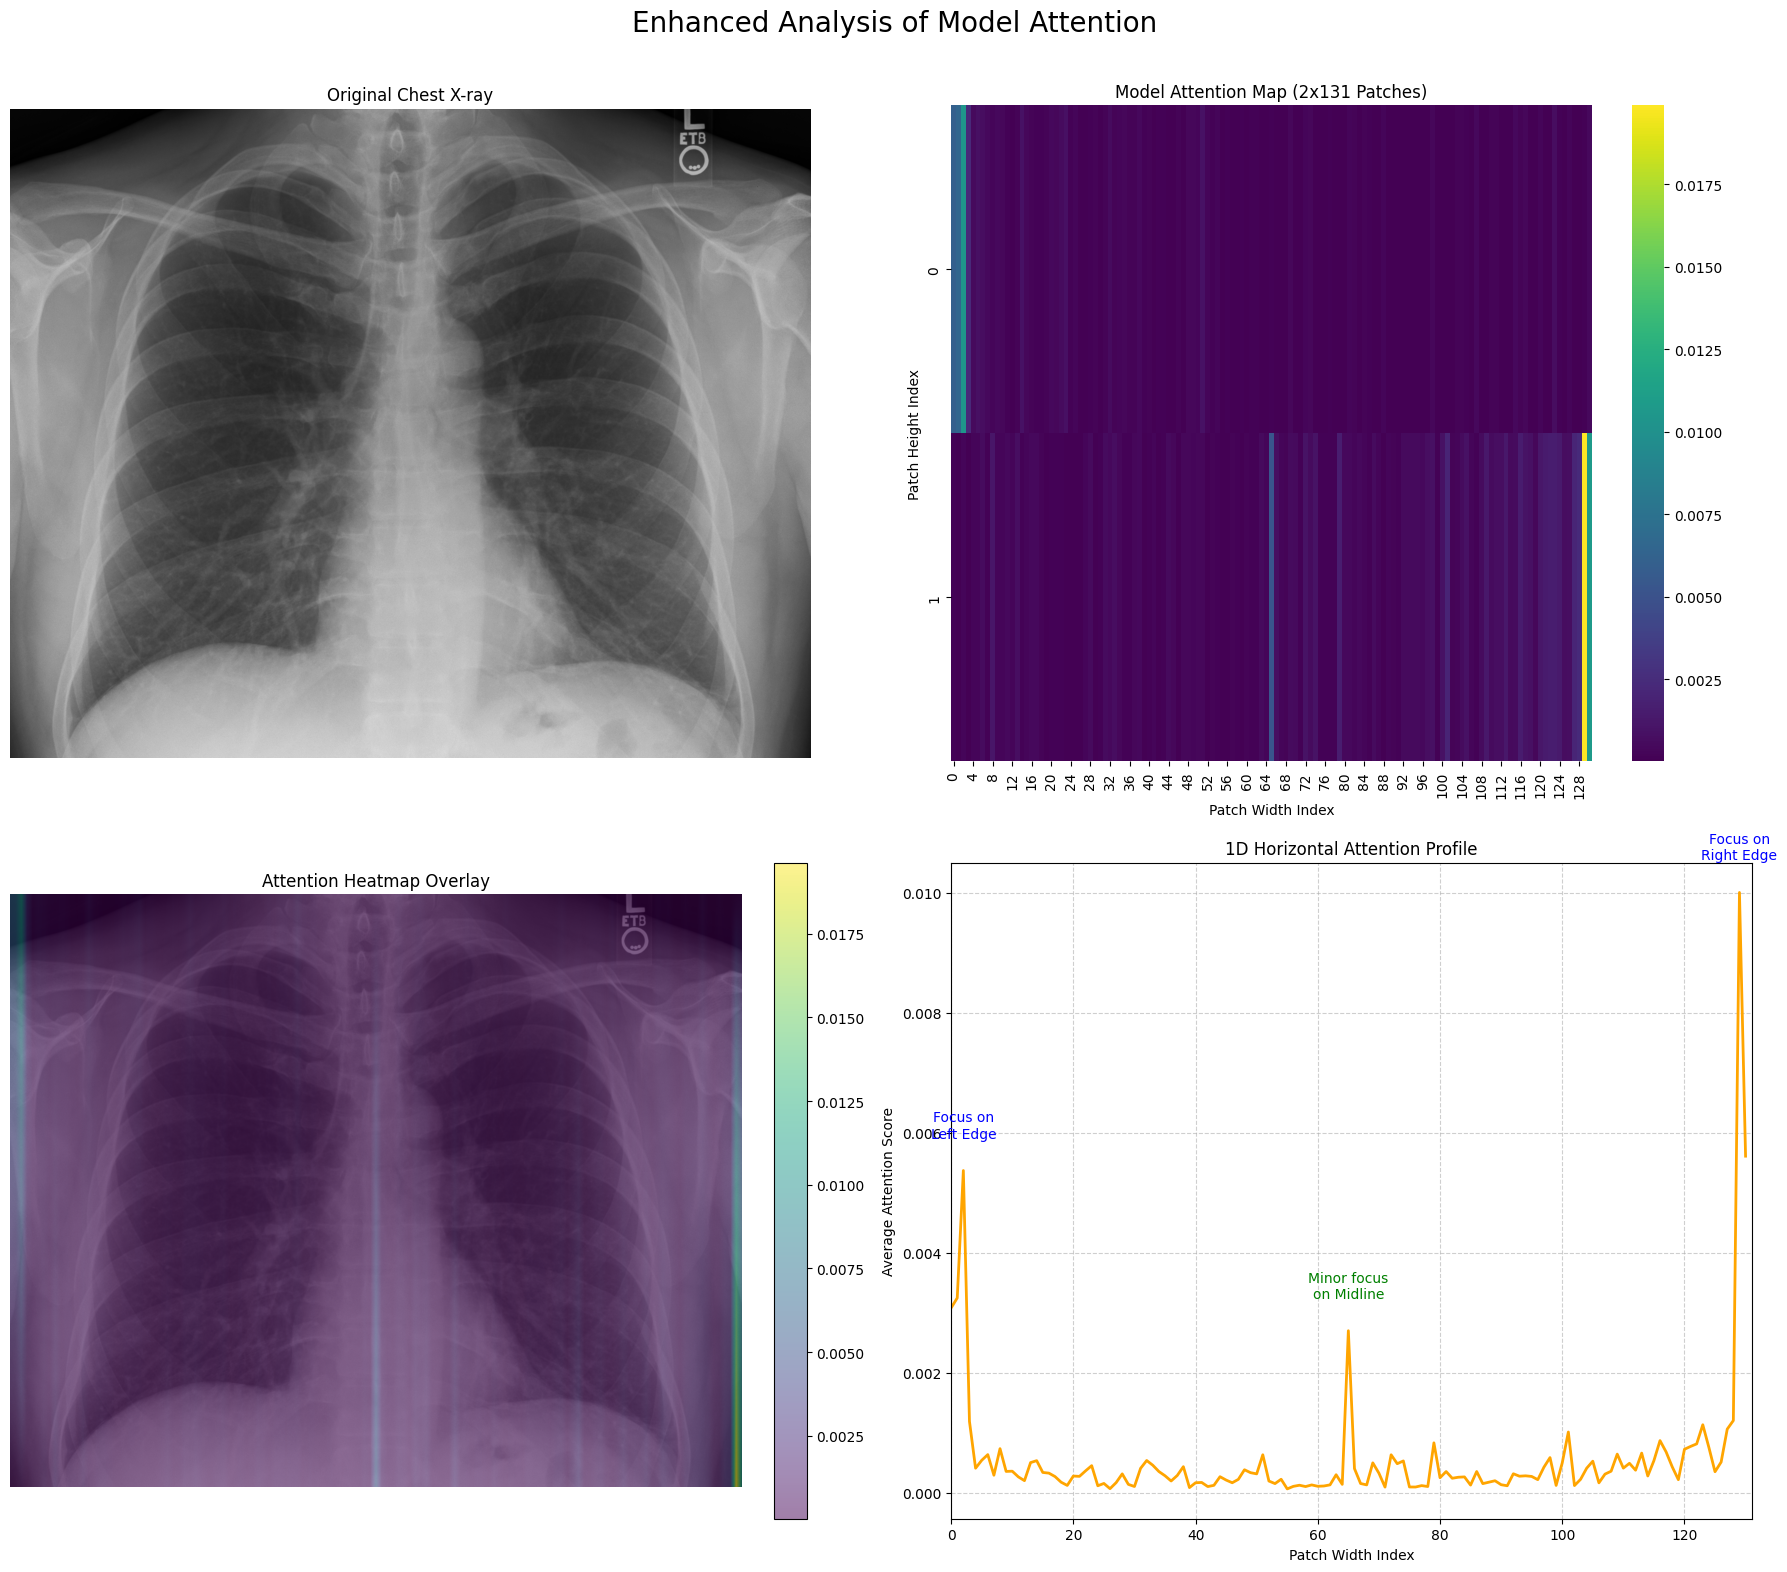

In [25]:
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from io import BytesIO
from scipy.ndimage import zoom

# 1. Load the image from the URL
image_url = "https://upload.wikimedia.org/wikipedia/commons/c/c8/Chest_Xray_PA_3-8-2010.png"
try:
    # Using wget is often faster in notebook environments
    !wget -q -O chest_xray.png {image_url}
    image = Image.open("chest_xray.png").convert("RGB")
except Exception:
    # Fallback to requests if wget is not available or fails
    print("wget failed, trying requests...")
    response = requests.get(image_url)
    response.raise_for_status() # Raise an exception for bad status codes
    image = Image.open(BytesIO(response.content)).convert("RGB")


device = model.device

# 2. Prepare multimodal input messages for the model
text_prompt = "Identify the lung fields in this chest X-ray."
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": text_prompt}
        ]
    },
]

# 3. Process inputs using the AutoProcessor
inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
)
inputs = {k: v.to(device) for k, v in inputs.items()}

# 4. Run forward pass to extract cross-attention scores
with torch.no_grad():
    outputs = model(
        **inputs,
        output_attentions=True, # Critical for this task
        return_dict=True
    )

# 5. Extract, Isolate, and Reshape the Cross-Attention Map
attn_map_reshaped = None
if hasattr(outputs, "attentions") and outputs.attentions:
    attn_map_raw = outputs.attentions[-1][0]

    # Ensure tensor is 4D for consistent processing
    if attn_map_raw.ndim == 3:
        attn_map_raw = attn_map_raw.unsqueeze(0)

    # Intelligently find the boundary between image and text tokens
    text_only_ids = tokenizer(text_prompt, add_special_tokens=False)['input_ids']
    full_input_ids_list = inputs['input_ids'][0].cpu().tolist()

    def find_sublist_start(haystack, needle):
        h_len, n_len = len(haystack), len(needle)
        for i in range(h_len - n_len + 1):
            if haystack[i:i+n_len] == needle:
                return i
        return -1

    text_start_index = find_sublist_start(full_input_ids_list, text_only_ids)
    if text_start_index == -1:
        raise ValueError("Could not find text prompt tokens in the input sequence.")

    num_vision_tokens = text_start_index
    num_text_tokens = len(text_only_ids)

    # Slice the attention map to isolate text-querying-image attention
    cross_attn_map = attn_map_raw[:, :, num_vision_tokens : num_vision_tokens + num_text_tokens, :num_vision_tokens]

    # Average scores and convert to a NumPy array
    attn_map_per_vision_token = cross_attn_map.mean(dim=(0, 1, 2))
    attn_map_per_vision_token_np = attn_map_per_vision_token.cpu().float().numpy()

    # The first vision token is often a global summary (like [CLS]), so we exclude it
    attn_map_for_grid = attn_map_per_vision_token_np[1:]
    effective_num_patches = len(attn_map_for_grid)

    # Dynamically determine the grid dimensions from the number of patches
    factors = [(i, effective_num_patches // i) for i in range(1, int(np.sqrt(effective_num_patches)) + 1) if effective_num_patches % i == 0]
    if not factors:
         raise ValueError(f"Could not find integer factors for {effective_num_patches} patches.")
    grid_h, grid_w = min(factors, key=lambda p: abs(p[0] - p[1]))

    print(f"Reshaping {effective_num_patches} patches into a {grid_h}x{grid_w} grid.")
    attn_map_reshaped = attn_map_for_grid.reshape((grid_h, grid_w))

# 6. Generate the Comprehensive 2x2 Visualization with Corrected Annotations
if attn_map_reshaped is not None:
    # --- Prepare data for the enhanced plots ---
    upscale_factors = (image.height / grid_h, image.width / grid_w)
    attention_map_upscaled = zoom(attn_map_reshaped, upscale_factors, order=1)
    attention_profile_1d = np.mean(attn_map_reshaped, axis=0)

    # --- Create the 2x2 plot dashboard ---
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))
    fig.suptitle('Enhanced Analysis of Model Attention', fontsize=20)

    # Plot 1: Original Image
    axes[0, 0].imshow(image)
    axes[0, 0].set_title("Original Chest X-ray")
    axes[0, 0].axis('off')

    # Plot 2: Raw Attention Heatmap
    sns.heatmap(attn_map_reshaped, ax=axes[0, 1], cmap="viridis")
    axes[0, 1].set_aspect('auto')
    axes[0, 1].set_title(f"Model Attention Map ({grid_h}x{grid_w} Patches)")
    axes[0, 1].set_xlabel("Patch Width Index")
    axes[0, 1].set_ylabel("Patch Height Index")

    # Plot 3: Attention Heatmap Overlay
    axes[1, 0].imshow(image)
    im = axes[1, 0].imshow(attention_map_upscaled, cmap='viridis', alpha=0.5)
    axes[1, 0].set_title("Attention Heatmap Overlay")
    axes[1, 0].axis('off')
    fig.colorbar(im, ax=axes[1, 0], orientation='vertical', fraction=0.046, pad=0.04)

    # Plot 4: 1D Horizontal Attention Profile
    ax_1d = axes[1, 1]
    ax_1d.plot(attention_profile_1d, color='orange', linewidth=2)
    ax_1d.set_title("1D Horizontal Attention Profile")
    ax_1d.set_xlabel("Patch Width Index")
    ax_1d.set_ylabel("Average Attention Score")
    ax_1d.grid(True, linestyle='--', alpha=0.6)
    ax_1d.set_xlim(0, len(attention_profile_1d)) # Ensure plot starts at 0

    # Horizontal attn profile

    # 1. Find the precise index of the highest peak in each half
    half_width = grid_w // 2
    left_peak_index = np.argmax(attention_profile_1d[:half_width])
    right_peak_index = np.argmax(attention_profile_1d[half_width:]) + half_width # Add offset to correct index

    # 2. Find the midline peak within a central zone for robustness
    midline_start = int(grid_w * 0.4)
    midline_end = int(grid_w * 0.6)
    midline_peak_index = np.argmax(attention_profile_1d[midline_start:midline_end]) + midline_start

    # 3. Get the Y-values (scores) at these peaks for precise vertical positioning
    left_peak_score = attention_profile_1d[left_peak_index]
    right_peak_score = attention_profile_1d[right_peak_index]
    midline_peak_score = attention_profile_1d[midline_peak_index]

    # 4. Use a small vertical offset so text appears just above the peak
    vertical_offset = np.max(attention_profile_1d) * 0.05

    # 5. Add the correctly placed annotations
    ax_1d.text(left_peak_index, left_peak_score + vertical_offset, 'Focus on\nLeft Edge',
                ha='center', va='bottom', color='blue')

    ax_1d.text(right_peak_index, right_peak_score + vertical_offset, 'Focus on\nRight Edge',
                ha='center', va='bottom', color='blue')

    ax_1d.text(midline_peak_index, midline_peak_score + vertical_offset, 'Minor focus\non Midline',
                ha='center', va='bottom', color='green')


    plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout for suptitle
    plt.show()

else:
    print("Could not extract attention maps from the model output.")